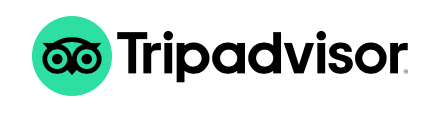
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
### Данные:

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

# Импортируем необходимые библиотеки

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
from collections import Counter
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

filenames_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        filenames_list.append(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler

/kaggle/input/positive-negative-words/adjectives.xlsx
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Methods

In [4]:
def reviews_date(rew, count): #из столбца "Reviews" забираем дату
    date = re.findall(r'\d\d?/\d\d?/\d+', str(rew))
    if len(date) == 0:
        return np.nan
    if count == 1:
        return pd.to_datetime(date[0])
    elif len(date) == 2:
        return pd.to_datetime(date[1])
    else:
        return np.nan


def reviews_text(rew, count): #из столбца "Reviews" забираем текст отзыва
    if rew == 0:
        return 'No review'
    date = re.findall(r'(\'\D+?\')', str(rew))
    if len(date) == 0:
        return 'No review'
    if count == 1:
        return date[0]
    elif len(date) > 1 and count == 2:
        return date[1]
    else:
        return np.nan


def review_to_numb(rew): #Сопоставление текста отзыва и сторонненго словаря с плохими/хорошими словами
    if rew == 'No review':
        return 0
    for i in rew:
        if i in positive_list:
            return 1
        elif i in negative_list:
            return -1
        else:
            return 0


def num_years(begin, end=None): #расчет диапазона времени, которое прошло с момента написания отзыва 
    if end is None:
        end = dt.now()
    if begin == 0:
        return 0
    delta_time = round(((end - begin).days / 365.25), 2)
    if delta_time > 10:
        return 0
    else:
        return delta_time


def for_city(rew, city): #избавляемся от мелких городов
    if rew in city:
        return rew
    else:
        return 'others'


def cuisine_func(rew, cuisine): # ручной get_dummies для столбца с кухнями (реализация ниже)
    if rew == 0:
        return 0
    for i in rew:
        count = 0
        if i in cuisine:
            count += 1
    if count > 0:
        return 1
    else:
        return 0


def fill_cuisine_nan(rew, cuisine): #отдельная функция, реагирующая на пустые значения 
    #(создано после предобработки для группы кухонь europ)
    if rew == 0:
        return 1
    for i in rew:
        count = 0
        if i in cuisine:
            count += 1
    if count > 0:
        return 1
    else:
        return 0

    
def fix_price_range(x): #преобразование столбца "Price Range"
        if x == None:
            return np.nan
        if x == '$':
            return 1
        if x == '$$ - $$$':
            return 2.5
        if x == '$$$$':
            return 4

    
def round_of_rating(number): #округление результатов  
    return np.round(number * 2) / 2

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
DATA_SUP = '/kaggle/input/positive-negative-words/adjectives.xlsx'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
positive = pd.read_excel(DATA_SUP, sheet_name = 'Sheet1', header = None) #список описательных слов с положительной эмоциональной окраской
negative = pd.read_excel(DATA_SUP, sheet_name = 'Sheet2', header = None) #список описательных слов с отрицательной эмоциональной окраской

# Проверяем файлы

In [6]:
sample_submission.sample(3)

,Restaurant_id,Rating
6407,id_6407,1.5
8223,id_8223,1.5
7113,id_7113,1.5


In [7]:
df_train.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
8578,id_10263,London,"['Bar', 'Pub', 'British']",10272.0,4.0,$$ - $$$,53.0,"[['Great pizzas served with a smile', 'simple ...",/Restaurant_Review-g186338-d3613532-Reviews-Re...,d3613532
249,id_11432,Paris,NaN,11434.0,4.0,NaN,15.0,"[[], []]",/Restaurant_Review-g187147-d1074698-Reviews-Pa...,d1074698
37538,id_1100,Oporto,NaN,1101.0,4.5,NaN,2.0,"[['Beach Bar'], ['07/09/2017']]",/Restaurant_Review-g189180-d12369037-Reviews-B...,d12369037


In [8]:
positive.sample(3)

,0
1683,Trustful
881,Jolif
1222,Prepotent


In [9]:
negative.sample(3)

,0
1366,russkie
1678,fistfucker
960,pole smoker


In [10]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
35273,id_13018,Paris,['French'],13020.0,$$ - $$$,173.0,"[['Home style Crepes', 'Best dessert crepe!'],...",/Restaurant_Review-g187147-d1950667-Reviews-La...,d1950667,1,3.0
18539,id_841,Warsaw,"['Japanese', 'Sushi']",842.0,$$ - $$$,19.0,"[['The best sushi in Warsaw', 'Sushi-licious!'...",/Restaurant_Review-g274856-d7156311-Reviews-Bu...,d7156311,1,5.0
3953,id_3953,Paris,"['French', 'European']",4275.0,$$ - $$$,136.0,"[['Friendly staff and good food', 'A great pla...",/Restaurant_Review-g187147-d2622171-Reviews-Le...,d2622171,0,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Результаты осмотра данных:
1. В данных присутствуют пропущенные значения, их необходимо заменить на наиоблее подходящие;
2. Переменные типа "object" необходимо обработать и записать в числовом виде.

# Cleaning and Prepping Data
   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

## 2. Обработка признаков

Обработка признака Restaurant_id не привела к улучшению модели, поэтому он тут опущен.

### 2.1 ID_TA

In [13]:
# Есть еще одна колонка, в которой есть уникальные id рестаранов.
df['ID_TA'].value_counts()

d1568045     2
d9802625     2
d2477531     2
d1028622     2
d7337366     2
            ..
d10528891    1
d7928509     1
d4727041     1
d10449936    1
d3968090     1
Name: ID_TA, Length: 49963, dtype: int64

In [14]:
# Создадим новый признак, фактически дигитализируем ID_TA
df['ID_TA'] = df['ID_TA'].apply(lambda x: float(x[1:]))

### 2.2 URL_TA

In [15]:
# Здесь тоже есть повторения, проверим как они сопостовляются со ссылками на рестораны.
df['URL_TA'].value_counts()

/Restaurant_Review-g187514-d7337366-Reviews-Lady_Madonna-Madrid.html                                    2
/Restaurant_Review-g187514-d4748208-Reviews-Restaurante_Te_Oriental-Madrid.html                         2
/Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html                                 2
/Restaurant_Review-g187514-d3161682-Reviews-Cerveceria_La_Surena-Madrid.html                            2
/Restaurant_Review-g187514-d4600226-Reviews-Cafeteria_Teresa-Madrid.html                                2
                                                                                                       ..
/Restaurant_Review-g187849-d10460420-Reviews-Micro-Milan_Lombardy.html                                  1
/Restaurant_Review-g274707-d2071240-Reviews-Restaurant_U_Tri_Pstrosu-Prague_Bohemia.html                1
/Restaurant_Review-g187849-d5853771-Reviews-Baretto_di_nino-Milan_Lombardy.html                         1
/Restaurant_Review-g189158-d2615867-Reviews-Na

In [16]:
# Из таблицы видно, что мы имеем дело с дубликатами ресторанов. Причем значение Ranking у них не одинаковые.
df[(df['URL_TA'].map(df['URL_TA'].value_counts()) == 2)].sort_values(by='ID_TA')

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
38096,id_1209,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1210.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,697406.0,1,4.0
14578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1181.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,697406.0,1,4.0
15240,id_2406,Madrid,"['Italian', 'French', 'European']",2408.0,$$ - $$$,148.0,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,793170.0,1,4.0
46822,id_2487,Madrid,"['Italian', 'French', 'European']",2489.0,$$ - $$$,148.0,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,793170.0,1,4.0
18019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,$$ - $$$,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...
26920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3538.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,11999956.0,1,4.0
1171,id_1171,Madrid,"['Indian', 'Asian', 'Nepali', 'Vegetarian Frie...",1219.0,$$ - $$$,22.0,"[['Fantastic food, Excellent service', 'Surpri...",/Restaurant_Review-g187514-d12488993-Reviews-K...,12488993.0,0,0.0
48967,id_1238,Madrid,"['Indian', 'Asian', 'Nepali', 'Vegetarian Frie...",1240.0,$$ - $$$,22.0,"[['Fantastic food, Excellent service', 'Surpri...",/Restaurant_Review-g187514-d12488993-Reviews-K...,12488993.0,1,5.0
36696,id_2485,Madrid,['American'],2487.0,$,6.0,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,13002276.0,1,5.0


In [17]:
# Дубликаты представлены в основном в Мадриде, но есть и в Варшаве.
df[(df['URL_TA'].map(df['URL_TA'].value_counts()) == 2)].sort_values(by='ID_TA').City.value_counts()

Madrid    70
Warsaw     4
Name: City, dtype: int64

In [18]:
# В признаке URL_TA содержиться информация о названии ресторана, о ID_TA ресторана, а так же ID города. Попробуем поменять значение признака.
df['City_url_ta'] = df.URL_TA.str.findall(r"g([\s\S]+?)-").str[0]

### 2.3 Ranking

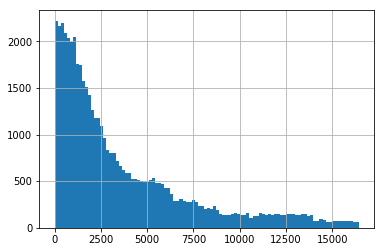

In [19]:
# Проверим распределение признака Ranking.
df['Ranking'].hist(bins=100)

Ниже число -  выше ранг. Он распределен между ресторанами в городе. Т.е. в каждом городе есть ресторан с наивысшим рангом, но не в каждом с большим числом. 

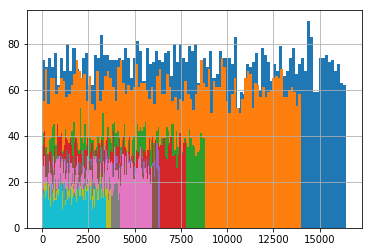

In [20]:
# На этом графике хорошо видно, что рейтинг нарямую зависит от колличества ресторанов в городе.
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [21]:
# Введем новую переменную, которая будет соответствовать количеству ресторанов в городе.
def ranking(df):
    reCount = df.City.value_counts()
    restCount = dict(reCount)
    df['DB_Restaurants_Count'] = df['City'].map(restCount)
    
    # Нормализуем данные так, что бы ранг ресторана не зависил от количества ресторанов в нем.
    mean_per_city = df.groupby('City')['Ranking'].mean()
    df['mean_ranking_per_city'] = df['City'].apply(lambda x: mean_per_city[x])
    max_per_city = df.groupby('City')['Ranking'].max()
    df['max_ranking_per_city'] = df['City'].apply(lambda x: max_per_city[x])
    df['standard_ranking'] = (df['Ranking'] - df['mean_ranking_per_city']) / df['max_ranking_per_city']
    
    return df

In [22]:
ranking(df).sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,City_url_ta,DB_Restaurants_Count,mean_ranking_per_city,max_ranking_per_city,standard_ranking
36267,id_9809,Paris,"['Chinese', 'Asian']",9811.0,$$ - $$$,72.0,"[['Good menu', 'Good Chinese Food'], ['10/01/2...",/Restaurant_Review-g187147-d2138896-Reviews-Au...,2138896.0,1,3.5,187147,6108,6938.557138,13986.0,0.205380
1835,id_1835,Vienna,"['Austrian', 'Bar', 'European', 'Central Europ...",79.0,$$ - $$$,186.0,"[['Tasty, friendly, good value', 'der Hannes -...",/Restaurant_Review-g190454-d784352-Reviews-Der...,784352.0,0,0.0,190454,1443,1711.275814,3444.0,-0.473948
22369,id_778,Budapest,"['European', 'Central European', 'Hungarian']",779.0,$$ - $$$,110.0,"[['Birthday', 'Great place'], ['11/18/2017', '...",/Restaurant_Review-g274887-d1057083-Reviews-To...,1057083.0,1,4.0,274887,1021,1219.061704,2440.0,-0.180353


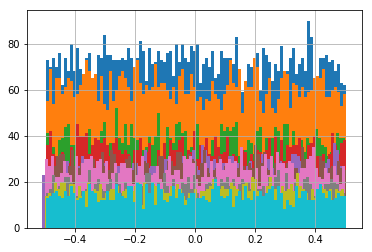

In [23]:
for x in (df['City'].value_counts())[0:10].index:
    df['standard_ranking'][df['City'] == x].hist(bins=100)
plt.show()

Смещение исчезло.

### 2.4 City

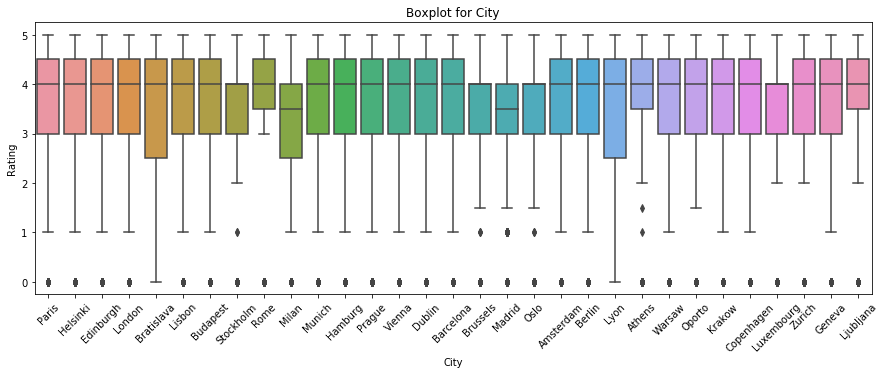

In [24]:
# Проверим распределение Rating по городам.
fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='City', y='Rating',data=df.loc[
    df.loc[:, 'City'].isin(df.loc[:, 'City'].value_counts().index[:])
],ax=ax)

plt.xticks(rotation=45)
ax.set_title('Boxplot for City')

plt.show()

In [25]:
#с помощью метода get_dummies создадим dummie переменные для городов, в которых больше 500 ресторановб остальные города
#назовём others

def city(df):
    popular_city = df.City.value_counts()
    popular_city = popular_city.loc[popular_city > 500].index.tolist()

    df['City'] = df['City'].apply(lambda x: for_city(x, popular_city))
    df_cities = pd.get_dummies(df['City'])
    df = pd.concat([df_cities, df], axis = 1)
    
    return df

In [26]:
# Cоздадим новый признак, в котором будет отражено является город столицей или нет.
def capital(df):
    Capitals = [
        'Athens', 'Bratislava', 'London', 'Paris', 'Madrid', 'Berlin', 'Rome',
        'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
        'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Edinburgh', 'Oslo',
        'Helsinki', 'Luxembourg', 'Ljubljana'
    ]
    df['is_capital'] = df['City'].apply(lambda x: 1 if x in Capitals else 0)
    return df

In [27]:
# Добавим население городов, а в пустые ячейки запишем среднее значение.
population = {
        'Paris': 2190327,
        'Stockholm': 961609,
        'London': 8908081,
        'Berlin': 3644826,
        'Munich': 1456039,
        'Oporto': 237591,
        'Milan': 1378689,
        'Bratislava': 432864,
        'Vienna': 1821582,
        'Rome': 4355725,
        'Barcelona': 1620343,
        'Madrid': 3223334,
        'Dublin': 1173179,
        'Brussels': 179277,
        'Zurich': 428737,
        'Warsaw': 1758143,
        'Budapest': 1752286,
        'Copenhagen': 615993,
        'Amsterdam': 857713,
        'Lyon': 506615,
        'Hamburg': 1841179,
        'Lisbon': 505526,
        'Prague': 1301132,
        'Oslo': 673469,
        'Helsinki': 643272,
        'Edinburgh': 488100,
        'Geneva': 200548,
        'Ljubljana': 284355,
        'Athens': 664046,
        'Luxembourg': 115227,
        'Krakow': 769498
    }


def population_city(df):
    df['Population'] = df['City'].map(population)
    df['Population'] = df['Population'].fillna(df.Population.mean())
    return df 

### 2.5 Price Range

In [28]:
df['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак).

In [29]:
#Исходя из логики обозначения цен в представленных ресторанах решено интерпретировать значения по возрастанию как 1, 2.5, 4.
#Такая градация позволит более точно определить средние значения цен в ресторанах, у которых пропущены эти значения

def price_range(df):
    df['Price Range'] = df['Price Range'].apply(lambda x: fix_price_range(x))
    df['Price Range'] = df['Price Range'].fillna(round(df['Price Range'].mean(), 1))
    return df


### 2.7 Cuisine Style

Для обработки данного признака найдены все уникальные названия кухонь и вручную распределены по крупным группам

In [30]:
veg = ['Vegetarian Friendly',
       'Vegan Options',
       'Gluten Free Options',
       'Healthy']
europ = ['European', 'Italian', 'French', 'Spanish',
         'British', 'Central European', 'German', 'Greek',
         'Halal', 'Czech', 'Eastern European', 'Austrian',
         'Polish', 'Hungarian', 'Scandinavian', 'Lebanese',
         'Dutch', 'Irish', 'Belgian', 'Swiss', 'Danish',
         'Swedish', 'Argentinean', 'Scottish', 'Ukrainian',
         'Norwegian', 'Slovenian', 'Russian', 'Portuguese', 'Australian',
         'Croatian', 'Singaporean', 'Romanian', 'Latvian']
mediterranean = ['Mediterranean', 'Seafood', 'Turkish', 'Delicatessen',
                 'Caribbean', 'New Zealand', 'Indonesian', 'Tunisian',
                 'Hawaiian', 'Malaysian', 'Cuban', 'Taiwanese', 'Jamaican',
                 'Sri Lankan', 'Filipino', 'Polynesian', 'Fujian']
asian = ['Asian', 'Japanese', 'Sushi', 'Chinese',  'Indian', 'Thai',
         'Vietnamese', 'Mexican',  'Korean', 'Pakistani',  'Caucasian',
         'Uzbek', 'Minority Chinese',  'Armenian', 'Central Asian',
         'Georgian', 'Israeli', 'Tibetan', 'Mongolian', 'Albanian', 'Azerbaijani']
fastfood = ['Pizza', 'Fast Food', 'Street Food']
american = ['Middle Eastern', 'American', 'Steakhouse', 'Barbecue', 'Grill', 'Gastropub',
            'South American', 'Latin', 'Central American', 'Brazilian', 'Colombian',
            'Chilean', 'Southwestern', 'Canadian', 'Native American']
african = ['African', 'Moroccan', 'Peruvian', 'Nepali', 'Balti', 'Bangladeshi', 'Persian',
           'Arabic', 'Kosher', 'Ethiopian', 'Venezuelan', 'Egyptian', 'Cajun ', 'Cambodian', 'Ecuadorean']
alco = ['Bar', 'Pub', 'Wine Bar', 'Brew Pub']
other_cusine = ['International', 'Cafe', 'Fusion', 'Soups', 'Contemporary',
                'Diner', 'Afghani', 'Creole', 'Welsh', 'Burmese', 'Yunnan', 'Salvadoran', 'Xinjiang']

def cuisine(df):
    df['Cuisine Style'] = df['Cuisine Style'].str.findall(r'\w+\s*\w*\s*\w*')
    df['Cuisine Style'] = df['Cuisine Style'].fillna(0)
#создание новых признаков типа dummie:
    df['veg'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, veg))
    df['mediterranean'] = df['Cuisine Style'].apply(
        lambda x: cuisine_func(x, mediterranean))
    df['asian'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, asian))
    df['fastfood'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, fastfood))
    df['american'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, american))
    df['african'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, african))
#с помощью pivot_table было определено, что в каждом городе больше всего кухонь из группы europ, 
#поэтому пустые значения заменены на europ
    df['europ'] = df['Cuisine Style'].apply(lambda x: fill_cuisine_nan(x, europ))
    df['alco'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, alco))
    df['other_cusine'] = df['Cuisine Style'].apply(
        lambda x: cuisine_func(x, other_cusine))
    return df

In [31]:
cuisine(df)
table = pd.pivot_table(df,
                       values=['veg', 'mediterranean', 'asian',
                               'fastfood', 'american', 'african',
                               'europ', 'alco', 'other_cusine'],
                       index='City',
                       aggfunc=np.sum)
display(table)

,african,alco,american,asian,europ,fastfood,mediterranean,other_cusine,veg
City,,,,,,,,,
Amsterdam,6,65,46,63,418,31,82,60,601
Athens,3,39,32,25,401,17,32,28,199
Barcelona,8,94,128,157,1595,85,264,109,955
Berlin,17,63,68,210,1312,86,103,115,731
Bratislava,0,32,9,18,223,19,9,23,47
Brussels,7,58,53,82,676,38,69,41,290
Budapest,3,39,24,35,526,37,9,40,308
Copenhagen,3,28,14,80,386,30,19,30,229
Dublin,1,77,21,55,244,33,5,35,365


### 2.8 Reviews

In [32]:
#список с позитивными словами
positive = pd.read_excel(DATA_SUP, sheet_name = 'Sheet1', header = None)
positive = positive.apply(lambda x: x.str.lower())
positive_list = positive[0].to_list()

#список с негативными словами
negative = pd.read_excel(DATA_SUP, sheet_name = 'Sheet2', header = None)
negative = negative.apply(lambda x: x.str.lower())
negative_list = negative[0].to_list()

def reviews(df):
    df.Reviews.fillna(df.Reviews.value_counts().index[0], inplace = True)
    df.Reviews = df.Reviews.apply(lambda x: str(x).replace('[[], []]', ''))
    df.Reviews = df.Reviews.replace('', np.nan, regex=True)
    df.Reviews = df.Reviews.fillna(0)
#обработка текста:
    df['reviews_text_1'] = df['Reviews'].apply(lambda x: reviews_text(x, 1))
    df['reviews_text_1'] = df['reviews_text_1'].apply(lambda x: str(x).replace("'", ""))
    df['reviews_text_1'] = df['reviews_text_1'].apply(lambda x: x.lower())
    df['reviews_text_1'] = df['reviews_text_1'].apply(lambda x: x.split(' '))

    df['reviews_text_2'] = df['Reviews'].apply(lambda x: reviews_text(x, 2))
    df['reviews_text_2'] = df['reviews_text_2'].apply(lambda x: str(x).replace("'", ""))
    df['reviews_text_2'] = df['reviews_text_2'].apply(lambda x: x.lower())
    df['reviews_text_2'] = df['reviews_text_2'].apply(lambda x: x.split(' '))
    
#превращение текста в цифровой вид:    
    df['reviews_text_1'] = df.reviews_text_1.apply(lambda x: review_to_numb(x))
    df['reviews_text_2'] = df.reviews_text_2.apply(lambda x: review_to_numb(x))

#обработка даты, вычисление количества времени, которое прошло после написания отзыва

    df['Reviews_time_1'] = df['Reviews'].apply(lambda x: reviews_date(x, 1))
    df['Reviews_time_1'] = df['Reviews_time_1'].fillna(0)
    df['Reviews_time_1'] = df['Reviews_time_1'].apply(lambda x: num_years(x))

    df['Reviews_time_2'] = df['Reviews'].apply(lambda x: reviews_date(x, 2))
    df['Reviews_time_2'] = df['Reviews_time_2'].fillna(0)
    df['Reviews_time_2'] = df['Reviews_time_2'].apply(lambda x: num_years(x))
    return df

### 2.9 Number of reviews

In [33]:
#Заполним пропуски, остальное без изменений 
df['Number of Reviews'].fillna(0, inplace=True)

In [34]:
def edit_number_of_reviews(input_df):
    # all about number_of_reviews
    
    df = input_df.copy()
    scaler = StandardScaler()
    # средний ранкинг для каждого города
    mean_per_city = df.groupby('City')['Number of Reviews'].mean()
    df['mean_Number_of_Reviews_per_city'] = df['City'].apply(lambda x: mean_per_city[x])

    #  масмимальный ранкинг для каждого города
    max_per_city = df.groupby('City')['Number of Reviews'].max()
    df['max_Number_of_Reviews_per_city'] = df['City'].apply(lambda x: max_per_city[x])
        
    # стандартизация
    df['stand_Number_of_Reviews'] = (df['Ranking'] - df['mean_Number_of_Reviews_per_city']) / df['max_Number_of_Reviews_per_city']
    
    # количество отзывов на каждого человека в городе
    try:
        df['reviews_per_each_person'] = df['Number of Reviews'] / df['population']
    except:
        pass

    # среднее количество отзывов по городам
    reviews_per_city = df.groupby(by='City')['Number of Reviews'].mean()
    df['reviews_per_city'] = df['City'].apply(lambda x: reviews_per_city[x])
    
    try:
        df['reviews_per_each_person'] = scaler.fit_transform(df[['reviews_per_each_person']])
    except:
        pass
  
    return df

# Data Preprocessing

In [35]:
#На всякий случай перегружаем данные еще раз
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
DATA_SUP = '/kaggle/input/positive-negative-words/adjectives.xlsx'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')


df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [36]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
        
    df = df_input.copy()
    
    ############################## 2.1 Restaurant_id  ###########################
    df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))
    #эта обработка не улучшила модель
    
    ############################## 2.2 ID_TA  ################################### 
    df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))
    
    ############################## 2.3 URL_TA  ################################### 
    df['City_url_ta'] = df.URL_TA.str.findall(r"g([\s\S]+?)-").str[0]

    ############################## 2.4 Ranking  #################################      
    df = ranking(df)
    
    ############################## 2.5 City   ###################################
    df = city(df)
    df = capital(df)
    population_city(df)
    
    ############################## 2.6 Price Range   ############################
    df = price_range(df)
    
    ############################## 2.7 Cuisine style ############################
    df = cuisine(df)

    ############################## 2.8 Reviews  #################################
    df = reviews(df)
    
    ############################## 2.8 Number of Reviews  #######################
    df['Number of Reviews'].fillna(0, inplace=True)
    edit_number_of_reviews(df)
    
    ############################## 2.9 Очистка данных  ##########################
    object_columns = [s for s in df.columns if df[s].dtypes == 'object']
    df.drop(object_columns, axis = 1, inplace=True)
     
    return df

#### Запускаем и проверяем что получилось

In [37]:
df_preproc = preproc_data(df)
df_preproc.sample(2)

,Amsterdam,Athens,Barcelona,Berlin,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,...,fastfood,american,african,europ,alco,other_cusine,reviews_text_1,reviews_text_2,Reviews_time_1,Reviews_time_2
20749,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3.15,3.22
11103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,7.20,0.00


In [38]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
Amsterdam                50000 non-null uint8
Athens                   50000 non-null uint8
Barcelona                50000 non-null uint8
Berlin                   50000 non-null uint8
Brussels                 50000 non-null uint8
Budapest                 50000 non-null uint8
Copenhagen               50000 non-null uint8
Dublin                   50000 non-null uint8
Edinburgh                50000 non-null uint8
Geneva                   50000 non-null uint8
Hamburg                  50000 non-null uint8
Krakow                   50000 non-null uint8
Lisbon                   50000 non-null uint8
London                   50000 non-null uint8
Lyon                     50000 non-null uint8
Madrid                   50000 non-null uint8
Milan                    50000 non-null uint8
Munich                   50000 non-null uint8
Oporto                   50000 non-null uint8
Paris            

### [Корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы можно заметить, как признаки связаны между собой и с целевой переменной.

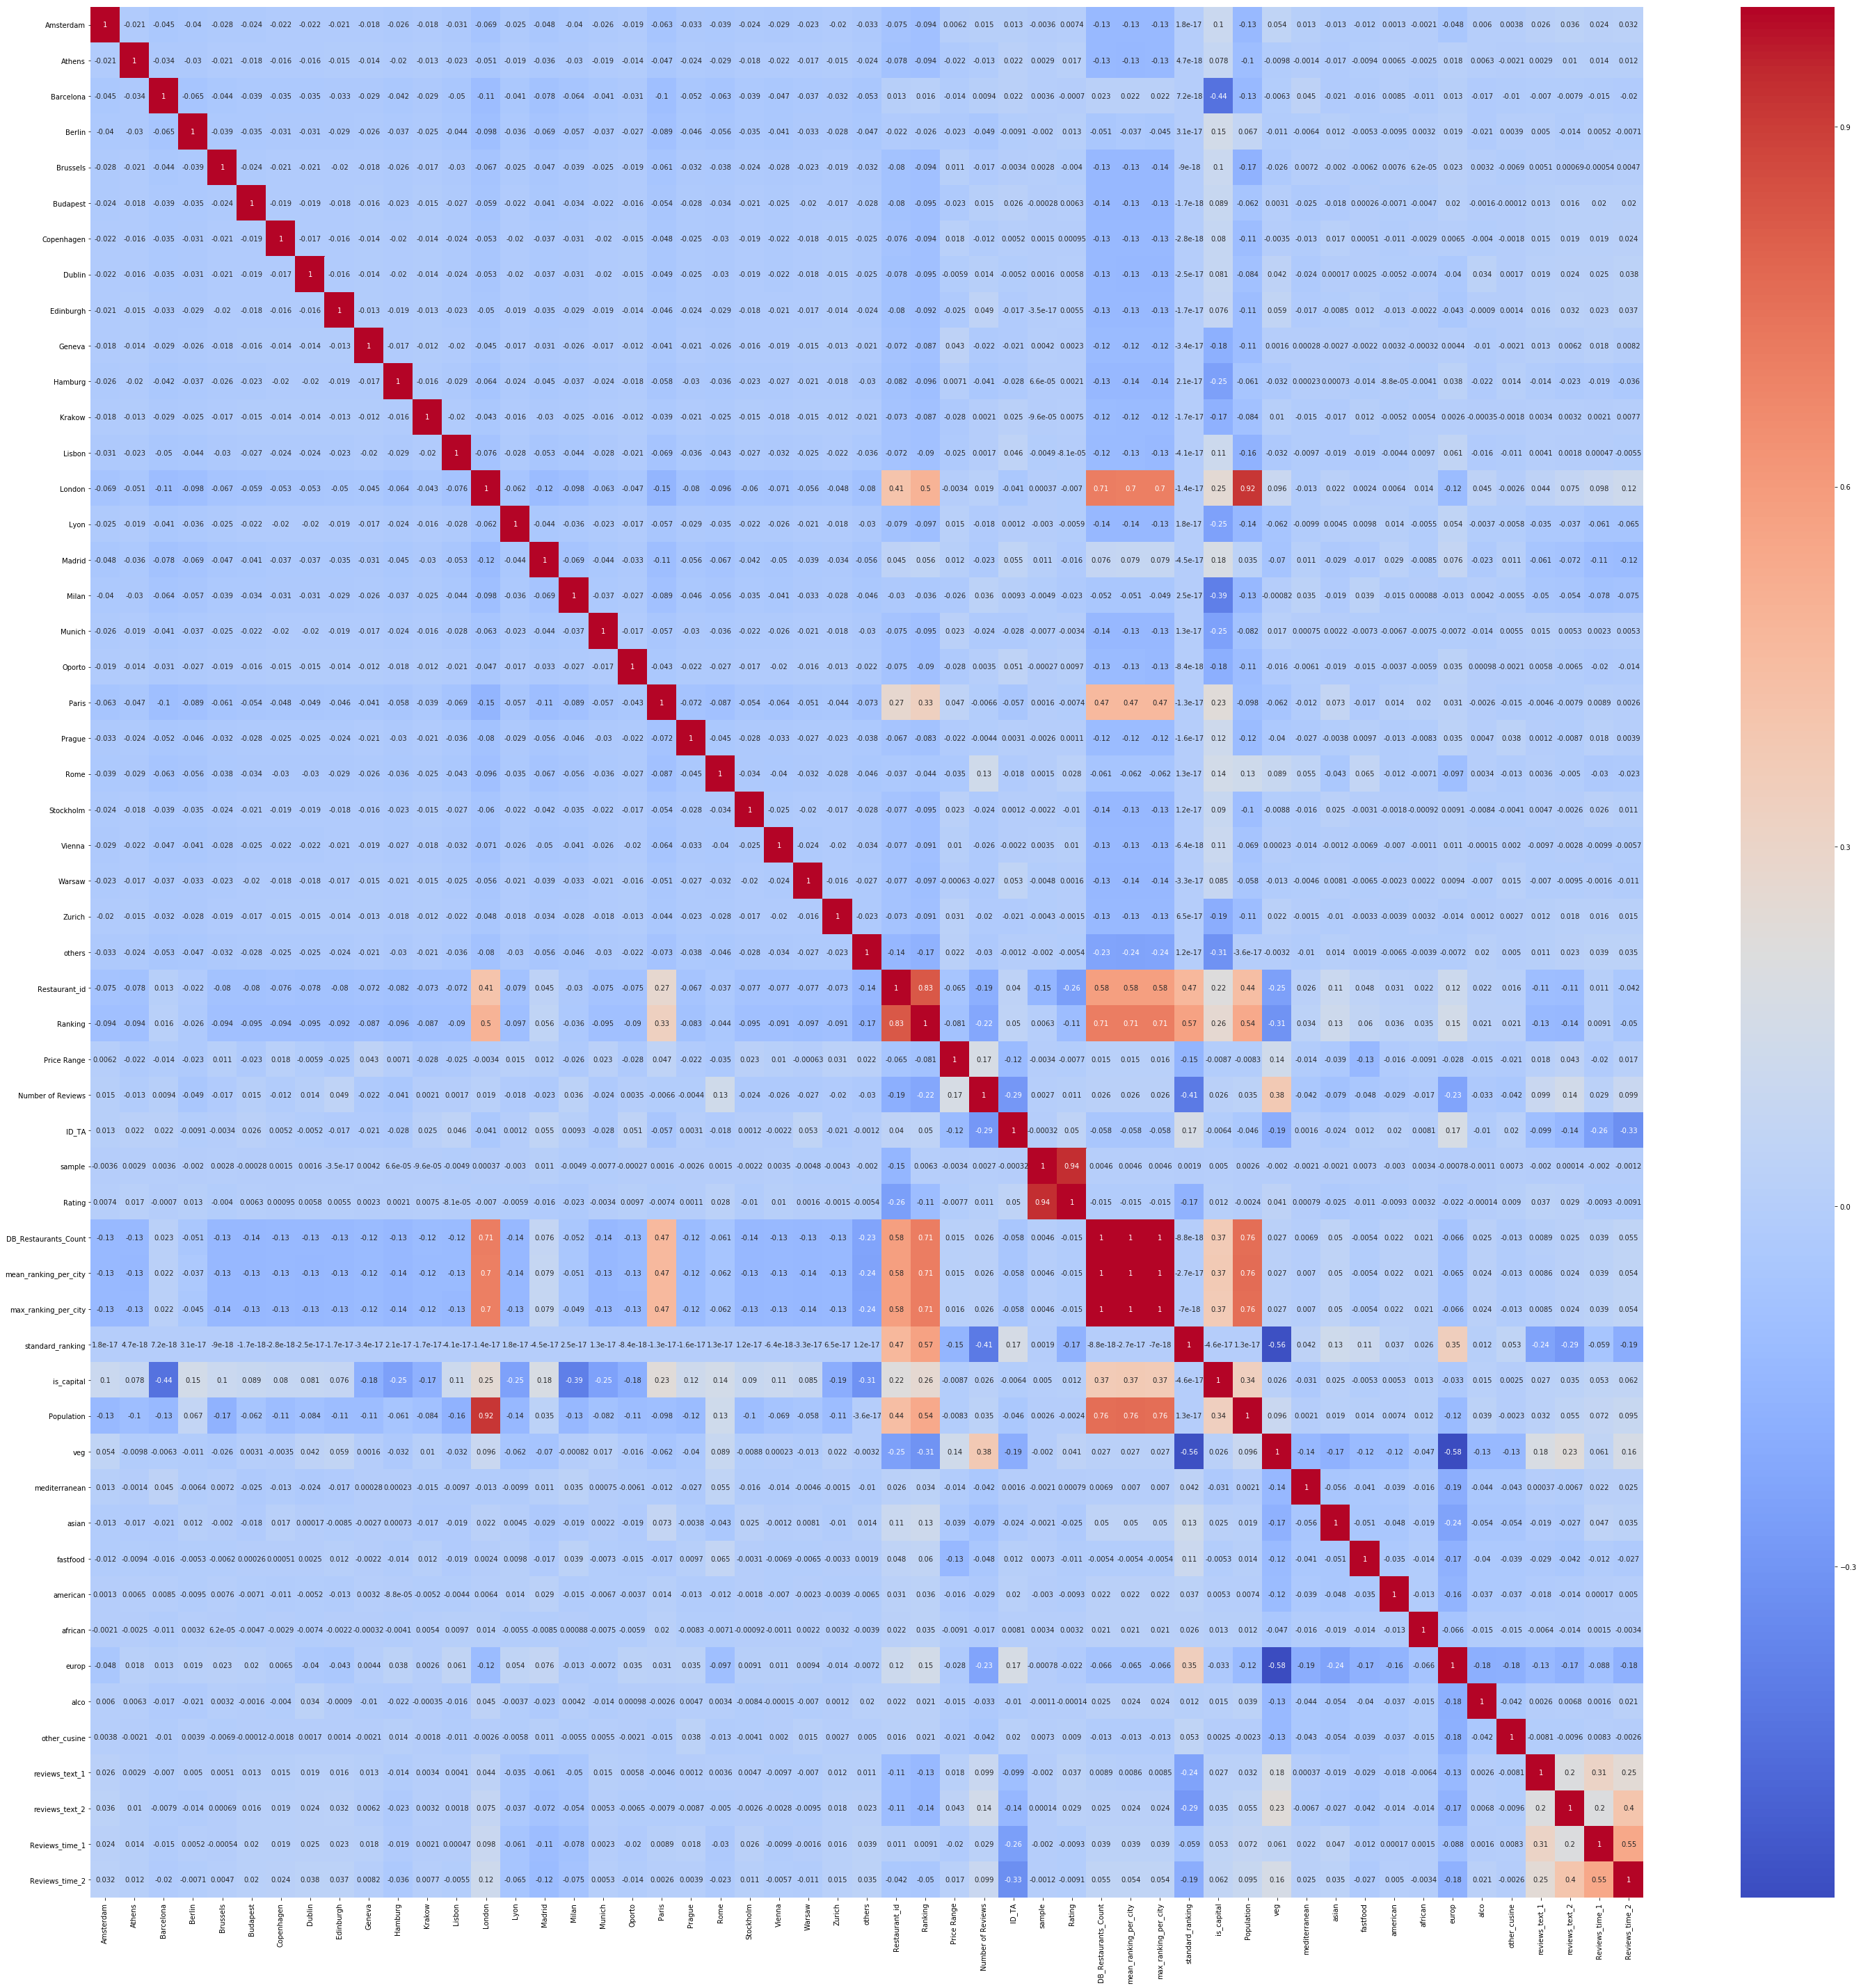

In [39]:
plt.rcParams['figure.figsize'] = (50.0, 50.0)
ax = sns.heatmap(df_preproc.corr(),annot = True, cmap = 'coolwarm')

Однако, сильно коррелирующие признаки не влияют на качество модели (если их удалить, МАЕ увеличивается)

In [40]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [41]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [42]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 52), (40000, 52), (40000, 51), (32000, 51), (8000, 51))

# Model 
Сам ML

In [43]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [44]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [45]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = round_of_rating(y_pred) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [46]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1665625


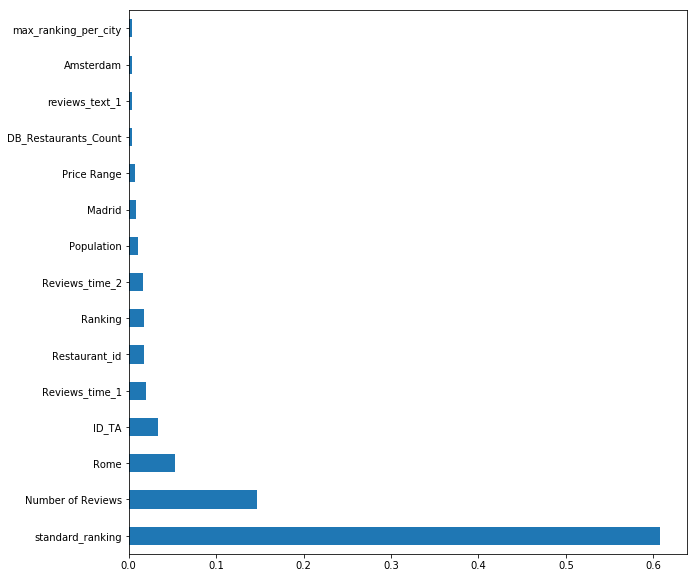

In [47]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Готовим Submission на кагл

In [48]:
# test_data = test_data.sort_values(by=['Restaurant_id'])
test_data.head(10)

,Amsterdam,Athens,Barcelona,Berlin,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,...,fastfood,american,african,europ,alco,other_cusine,reviews_text_1,reviews_text_2,Reviews_time_1,Reviews_time_2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.00,0.00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,3.07,3.17
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,3.01,3.07
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,3.07,3.10
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2.89,2.93
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,3.31,3.33
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.00,0.00
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0.00,0.00
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,2.98,3.22
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,3.08,3.17


In [49]:
test_data = test_data.drop(['Rating'], axis=1)

In [50]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [51]:
predict_submission = model.predict(test_data)
predict_submission = np.round(predict_submission*2) / 2

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [52]:
predict_submission

array([3.5, 4. , 4. , ..., 3. , 4.5, 4. ])

In [53]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission6.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
